In [2]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import pickle
import matplotlib.pyplot as plt

from estimator import Estimator

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [3]:
def parse(s):
    split = s.split(',')
    n = np.zeros(len(split))
    for i in range(len(split)):
        n[i] = float(split[i])
    return n

In [4]:
num_observations = 1268140
with open("demonstrations_10k") as f:
    s_arr = np.zeros((11, num_observations))
    r_arr = np.zeros((1, num_observations))
    a_arr = np.zeros((3, num_observations))
    sprime_arr = np.zeros((11, num_observations))
    
    i = 0

    for l in f:
        if len(l.strip().split(';')) <= 1:
            continue
    
        i += 1
        s, r, a, sp = l.strip().split(';')
        s_arr[:,i] = parse(s)
        r_arr[:,i] = parse(r)
        a_arr[:,i] = parse(a)
        sprime_arr[:, i] = parse(sp)


In [10]:
s_arr = np.swapaxes(s_arr, 0, 1)
r_arr = np.swapaxes(r_arr, 0, 1)
a_arr = np.swapaxes(a_arr, 0, 1)
sprime_arr = np.swapaxes(sprime_arr, 0, 1)

In [11]:
with open('estimator25.pkl', 'rb') as pkl:
    estimator = pickle.load(pkl)

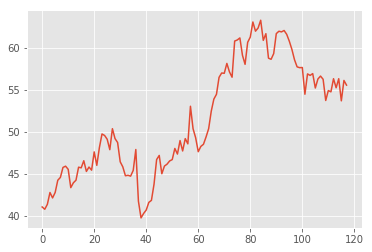

In [12]:
values = [estimator.predict(s) for s in s_arr[1:119,:]]
plt.plot(values)

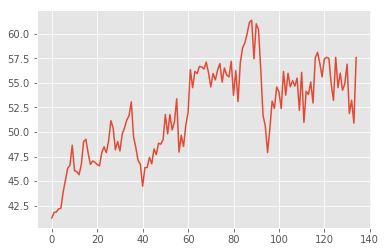

In [13]:
values = [estimator.predict(s) for s in s_arr[119:254,:]]
plt.plot(values)

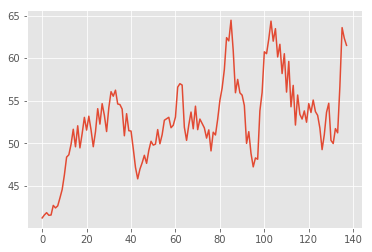

In [14]:
values = [estimator.predict(s) for s in s_arr[254:392,:]]
plt.plot(values)

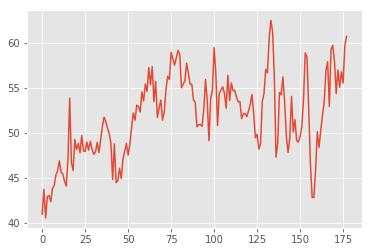

In [15]:
values = [estimator.predict(s) for s in s_arr[392:570,:]]
plt.plot(values)

In [16]:
num_observations = 1268140
with open("demonstrations_10k") as f:
    i = 0

    for l in f:
        if len(l.strip().split(';')) <= 1:
            print(i)
        i += 1
        if i == 5000:
            break

118
254
393
572
709
817
936
1023
1158
1328
1454
1580
1686
1809
1934
2049
2187
2307
2460
2602
2725
2845
3007
3133
3269
3401
3532
3667
3782
3917
4041
4152
4277
4421
4544
4674
4808
4919
